# What's cooking
What's cooking is a competition hosted by [Kaggle](https://www.kaggle.com/c/whats-cooking). You are provided a list of recipies which contain ingredients and a cuisine. It is your task to predict the cuisine of a recipe based on those ingredients.

To get started lets first import all the libraries we need. Why we need those will become apparent when looking at the code.
Unzip the `train.json` and `test.json`, you get can them from [here](https://github.com/stretchhog/playing-with-data/blob/master/whats-cooking/whats-cooking.rar) and place them in the working directory as specified below.

In [130]:
%matplotlib inline

import json, re, os
import numpy as np

from pandas import DataFrame, Series, pivot_table

from sklearn.preprocessing import LabelEncoder
from sklearn import svm, cross_validation
from sklearn.cross_validation import ShuffleSplit
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import chi2, SelectKBest

from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize

import matplotlib.pyplot as plt
import matplotlib
import mpld3
%matplotlib inline
matplotlib.style.use('ggplot')
# mpld3.enable_notebook()

# Loading the data
We start with loading the data from `train.json` into a `pandas` `dataframe`. While reading the ingredients they are cleaned before being stored in the dataframe.
The cleaning consists of removed common words as specified below in `filter_list`, removing any numbers and punctuation, stripping whitespace, converting the ingredients to lowercase and lastly the ingredients are lemmatized using the  `WordNetLemmatizer` from [`nltk`](http://www.ntlk.org)

In [2]:
filter_list = ['shredded', 'sliced', 'diced', 'chopped', 'seasoned', 'dried', 'fresh', 'cubed', 'peeled']
word_pattern = re.compile('|'.join(filter_list))
wnl = WordNetLemmatizer()

def extract_recipe(json):
    return {
        'id': get_attribute_from_json('id', json),
        'cuisine': get_attribute_from_json('cuisine', json),
        'ingredients': [clean_ingredient(i) for i in get_attribute_from_json('ingredients', json)]
    }

def get_attribute_from_json(attr, json):
    if attr in json:
        return json[attr]
    return ''

def clean_ingredient(i):
    retval = word_pattern.sub("", i)
    retval = re.sub("[^a-zA-Zé ]", "", retval)
    retval = retval.rstrip().lstrip().lower()
#     retval = lemmatize(retval)
    return retval

def lemmatize(ingredient):
    return " ".join([wnl.lemmatize(t) for t in word_tokenize(ingredient)])

After defining the helper function we can read the data into the `dataframe`. This takes a while :)

In [10]:
filename = 'resources\\train.json'
df = DataFrame([extract_recipe(recipe) for recipe in json.load(open(filename))])
encoder = LabelEncoder()
df['cuisine_encoded'] = encoder.fit_transform(df['cuisine'])

The data now looks like the table below. Those who are familiar with R's data frames recognize this structure.

In [11]:
df.head(6)

,cuisine,id,ingredients,cuisine_encoded
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...",6
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...",16
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...",4
3,indian,22213,"[water, vegetable oil, wheat, salt]",7
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...",7
5,jamaican,6602,"[plain flour, sugar, butter, eggs, ginger root...",10


## Converting to numpy
We have decided to create a sparse boolean matrix where each row represents an observation, a recipe, and each column is an ingredient from the entire `train.json`. For the column/ingredient that occurs in the observation/recipe we place a `1` in the matrix.

In [183]:
def construct_data_matrix(df, ingredients):
    lens = [len(i) for i in df.ingredients]
    R = np.repeat(np.arange(len(lens)),lens)
    C = np.searchsorted(ingredients, np.concatenate(df.ingredients.values))
    
    x = np.zeros((len(df), len(ingredients)))    
    x[R, C] = 1
    return x

def stack_ingredients(df):
    return df.ingredients.str.split(', ').apply(lambda x: Series(x)).stack().reset_index(level=1, drop=True)

def get_unique_sorted_ingredients(df):
    return np.array(sorted(set(np.concatenate(df.ingredients.values))))

In [184]:
unique_sorted_ingredients = get_unique_sorted_ingredients(df)
x = construct_data_matrix(df, unique_sorted_ingredients)
y = df.cuisine_encoded.values

The matrix `x` and the vector `y` look like this:

In [185]:
x

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [186]:
y

array([ 6, 16,  4, ...,  8,  3, 13], dtype=int32)

# Playing with the data

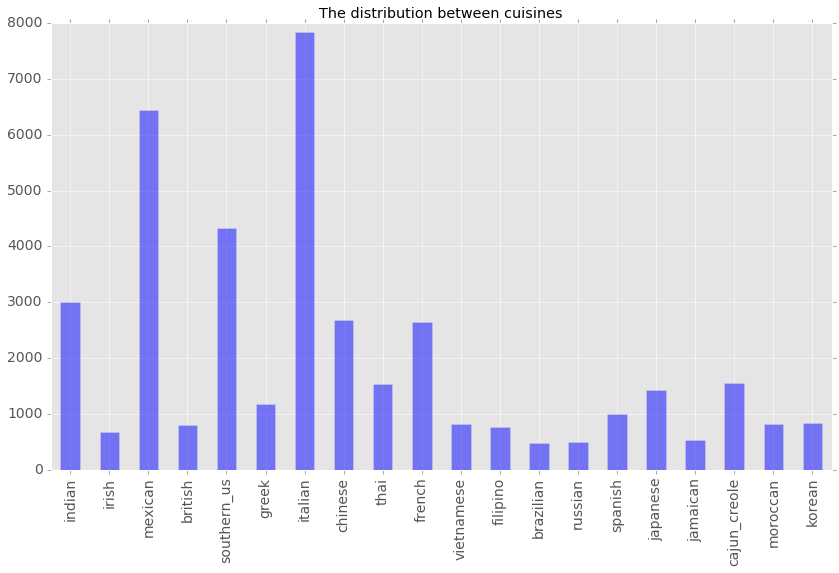

In [135]:
df.cuisine.value_counts(sort=False).plot(
    kind='bar', alpha=0.5, x='cuisines', y='nr of recipes', title='The distribution between cuisines',
    figsize=(14, 8), fontsize=14)

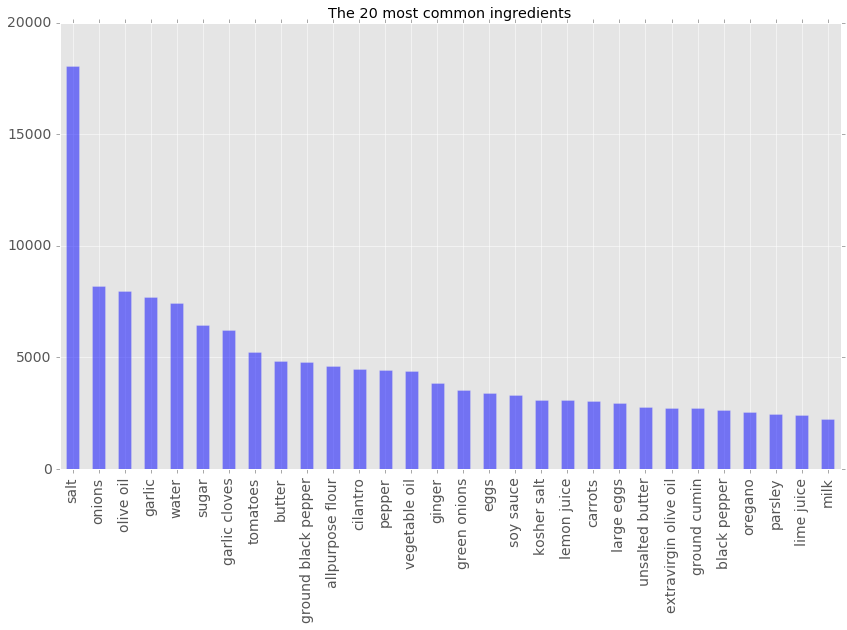

In [95]:
s = Series(np.concatenate(df.ingredients.values)).value_counts()[:30]
s.plot(kind='bar', alpha=0.5, x='ingredients', y='nr of recipes', title='The 20 most common ingredients',
       figsize=(14, 8), fontsize=14)

In [40]:
dfx = DataFrame(x, columns = unique_sorted_ingredients)
dfx['cuisine'] = df.cuisine

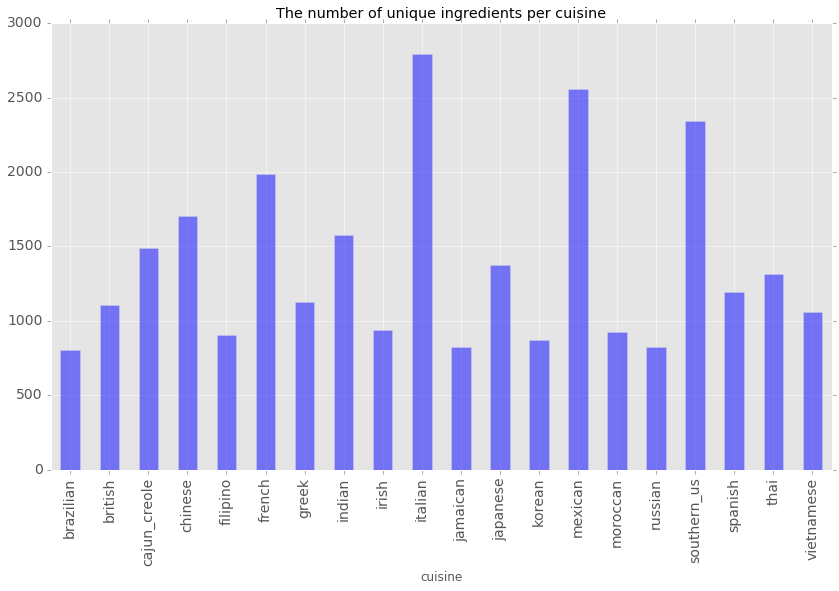

In [93]:
r = pivot_table(dfx, index='cuisine').transpose().apply(np.count_nonzero)
r.plot(kind='bar', alpha=0.5, x='cuisine', y='nr of recipes', title='The number of unique ingredients per cuisine',
       figsize=(14, 8), fontsize=14)

We can see in the plot below that even though common ingredients are kept by the feature selector, they are present in very different quantities in the various cuisines. A good machine learning model is capable of utilizing that information and creates a good predictor

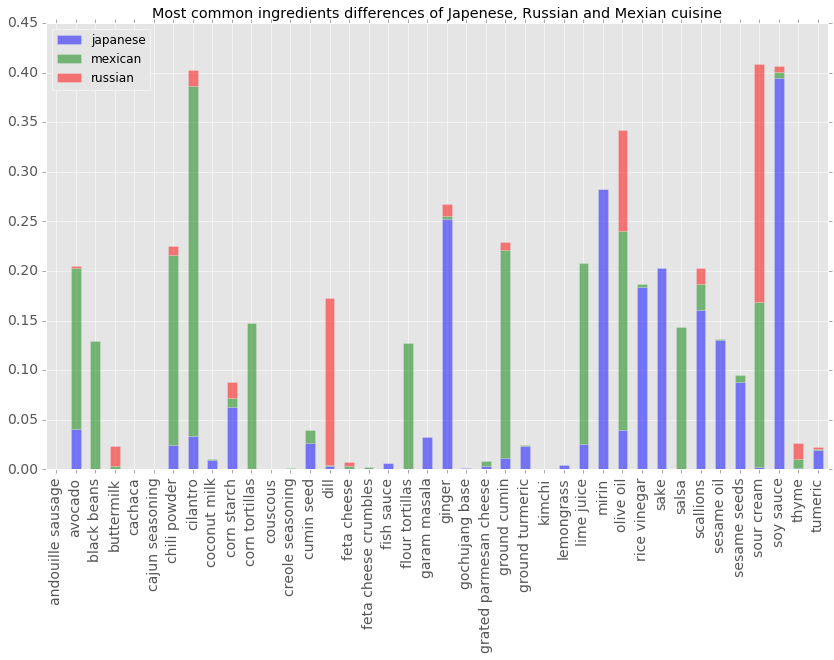

In [296]:
selector2 = SelectKBest(chi2, k=40).fit(x, y)
r = pivot_table(dfx, index='cuisine').transpose()
r = r[selector2.get_support()]
df2 = DataFrame(r.japanese)
df2['mexican']= r.mexican
df2['russian']= r.russian
df2.plot(kind='bar', alpha=0.5, stacked=True, title='Most common ingredients differences of Japenese, Russian and Mexian cuisine', figsize=(14, 8), fontsize=14)

We can also that the cuisines japanese and chinese use a lot of the same ingredients with the same frequency

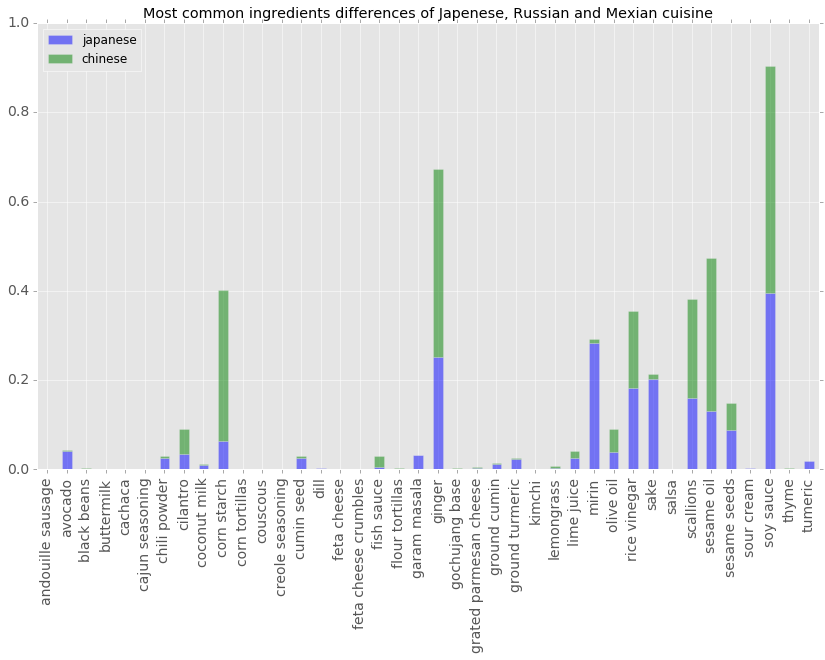

In [300]:
df2 = DataFrame(r.japanese)
df2['chinese']= r.chinese
df2.plot(kind='bar', alpha=0.5, stacked=True, title='Most common ingredients differences of Japenese and Chinese cuisine', figsize=(14, 8), fontsize=14)

# Benchmarking models
Now we are finally ready to benchmark some machine learning models to see which one performs well. We'll define a function that takes the `x` and `y` as we defined them and in addition to that a list that contains the number of features we want to give to the [feature selector](https://en.wikipedia.org/wiki/Feature_selection) and a list of models we want to give to the [cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) function.

In addition to benchmarking, the function also returns the best model based on the accuracy metric.

In [301]:
def benchmark_models(x_train, y, **kwargs):
    results = []
    n_samples = x_train.shape[0]
    for nr in kwargs['nr_of_features']:
        x_train_new = feature_selection(x_train, y, nr)
        for model in kwargs['models']:
            scores = cross_validation.cross_val_score(model, x_train_new, y,
                                                      cv=ShuffleSplit(n_samples, n_iter=10, test_size=0.1))
            results.append((model, nr, scores.mean(), scores.std() * 2))

    return results


def print_results(results):
    for res in results:
        print("\tModel: %s | Features: %s | Accuracy: %0.5f (+/- %0.3f)" % (
                res[0].__class__.__name__, res[1], res[2], res[3]))


def get_best(results):
    return sorted(results, key=lambda r: r[2], reverse=True)[0]


def feature_selection(x, y, nr_features):
    selector = SelectKBest(chi2, k=nr_features).fit(x, y)
    x_new = selector.transform(x)
    return x_new

In [ ]:
results = benchmark_models(x, y, 
                        nr_of_features=[100, 200, 500, 1000, 1500, 2000, 2500], 
                        models=[svm.LinearSVC(), BernoulliNB(), LogisticRegression()])

In [303]:
print_results(results)

	Model: LinearSVC | Features: 100 | Accuracy: 0.59786 (+/- 0.020)
	Model: BernoulliNB | Features: 100 | Accuracy: 0.59545 (+/- 0.009)
	Model: LogisticRegression | Features: 100 | Accuracy: 0.60294 (+/- 0.023)
	Model: LinearSVC | Features: 200 | Accuracy: 0.66297 (+/- 0.013)
	Model: BernoulliNB | Features: 200 | Accuracy: 0.64595 (+/- 0.011)
	Model: LogisticRegression | Features: 200 | Accuracy: 0.66719 (+/- 0.018)
	Model: LinearSVC | Features: 500 | Accuracy: 0.73258 (+/- 0.015)
	Model: BernoulliNB | Features: 500 | Accuracy: 0.69995 (+/- 0.016)
	Model: LogisticRegression | Features: 500 | Accuracy: 0.73157 (+/- 0.017)
	Model: LinearSVC | Features: 1000 | Accuracy: 0.76456 (+/- 0.011)
	Model: BernoulliNB | Features: 1000 | Accuracy: 0.73532 (+/- 0.010)
	Model: LogisticRegression | Features: 1000 | Accuracy: 0.76621 (+/- 0.009)
	Model: LinearSVC | Features: 1500 | Accuracy: 0.77559 (+/- 0.007)
	Model: BernoulliNB | Features: 1500 | Accuracy: 0.73959 (+/- 0.011)
	Model: LogisticRegressio

It is clearly visible that although the boolean version of Naive Bayes (which uses the [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution)) is doing a good job it is mariginally outperformed by [Linear support vector machines](https://en.wikipedia.org/wiki/Support_vector_machine#Linear_SVM) and [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression) with support vector machines (by a very small margin) the winner.

In [305]:
best = get_best(results)
print("\tModel: %s | Features: %s | Accuracy: %0.5f (+/- %0.3f)" % (
                best[0].__class__.__name__, best[1], best[2], best[3]))

	Model: LinearSVC | Features: 2500 | Accuracy: 0.78117 (+/- 0.013)


The plot below shows the weights assigned to each feature by the feature selector. Here it is quite apparent that we are dealing with a very sparse matrix as the feature selector assings high weights to a significant number of features. The benchmarking result also shows that the optimimum number of features is somewhere around 2000.
This can be improved in the future by using gradient descend to find the optimum number of features.

<Container object of 6461 artists>

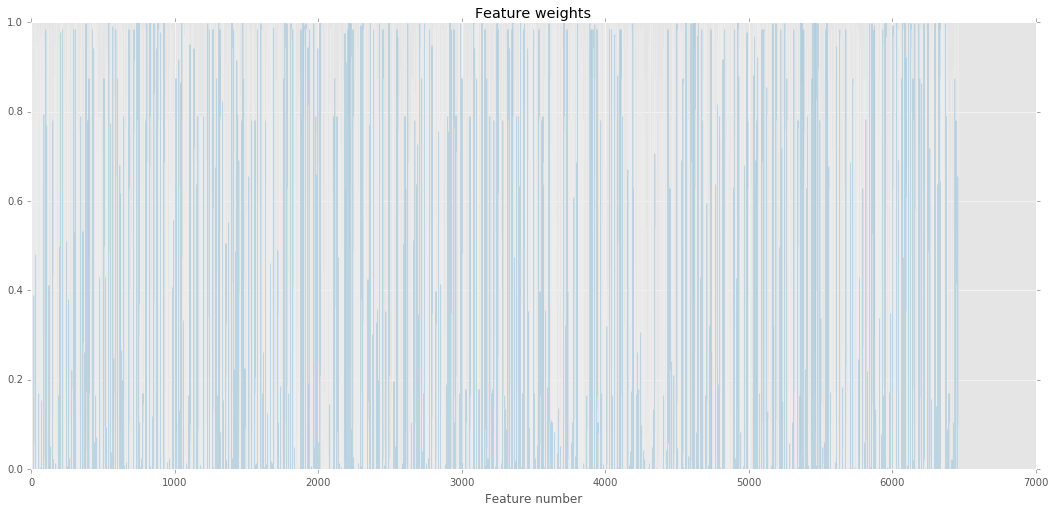

In [297]:
scores = selector.pvalues_
X_indices = np.arange(x.shape[-1])
plt.figure(figsize=(18, 8))
plt.title("Feature weights")
plt.xlabel('Feature number')
plt.bar(X_indices, scores, width=1)